## Imports

In [9]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

# Qiskit
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit import ParameterVector
from qiskit.circuit.library import RealAmplitudes
from qiskit.quantum_info import SparsePauliOp
from qiskit.primitives import StatevectorEstimator, StatevectorSampler
from qiskit_machine_learning.neural_networks import SamplerQNN, EstimatorQNN
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit_machine_learning.optimizers import COBYLA
from qiskit_machine_learning.utils import algorithm_globals

# Local Modules
from qcnn.datasets import generate_line_dataset   
from qcnn.model import qcnn
from qautoencoder.qautoencoder import prep_feature_map, to_angles, encoder_ansatz, qae_training_circuit, build_trained_encoder_only




## Setup

In [12]:
estimator = StatevectorEstimator()
sampler = StatevectorSampler()

# Sizes
width, height = 3, 2 # image dimensions
D = width * height
m = 4 # qubits to keep
assert 0 < m <= D, "m must be in (0, D]"

print(f"Input dimension D={D}, latent m={m}, trash k={D-m}, training-circuit qubits: {m + 2*(D-m) + 1}")

Input dimension D=6, latent m=4, trash k=2, training-circuit qubits: 9


## Dataset Creation

In [13]:
N = 600  # total samples (
images, labels = generate_line_dataset(N, width=width, height=height, min_l=2, max_l=2)
X = np.asarray(images).reshape(N, D).astype(float)
y = (np.asarray(labels) == 1).astype(int)

# train/val/test split
from sklearn.model_selection import train_test_split
X_train, X_tmp, y_train, y_tmp = train_test_split(X, y, test_size=0.30, random_state=246, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_tmp, y_tmp, test_size=0.50, random_state=246, stratify=y_tmp)

print(X_train.shape, X_val.shape, X_test.shape)

(420, 6) (90, 6) (90, 6)


## Train the Quantum Autoencoder only

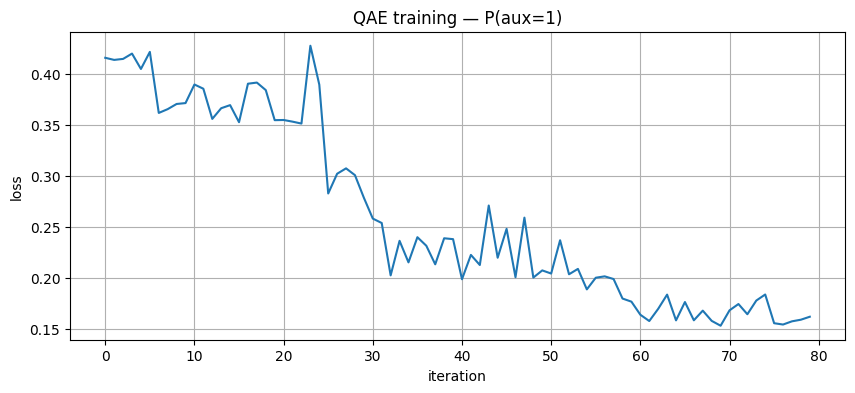

QAE training done. Final loss: 0.161773681640625


In [16]:
# Build the QAE training circuit for (D -> m)
reps_enc = 3  # encoder depth
qc_qae, enc_params, fm_params = qae_training_circuit(D=D, m=m, reps=reps_enc)

# SamplerQNN that outputs [P(aux=0), P(aux=1)]
def identity_interpret(x): return x
qnn_qae = SamplerQNN(
    circuit=qc_qae,
    input_params=fm_params, # per-sample feature angles
    weight_params=enc_params, # trainable encoder weights
    interpret=identity_interpret,
    output_shape=2,
    sampler=sampler,
)

# Mini-batch loss: average P(aux == 1)
def batch_to_angles(batch_flat):
    return np.stack([to_angles(v) for v in batch_flat], axis=0)

obj_vals = []
def qae_loss(weights, X_batch):
    probs = qnn_qae.forward(batch_to_angles(X_batch), weights) # [B,2]
    cost  = float(np.mean(probs[:, 1])) # want to minimize this
    obj_vals.append(cost)
    return cost

# Optimizer
def train_qae(X_train, maxiter=200, batch_size=128):
    opt = COBYLA(maxiter=maxiter)
    w0  = algorithm_globals.random.random(len(enc_params))

    def f(w):
        idx = np.random.choice(len(X_train), size=min(batch_size, len(X_train)), replace=False)
        c = qae_loss(w, X_train[idx])
        # live plot
        clear_output(wait=True)
        plt.figure(figsize=(10,4))
        plt.plot(obj_vals)
        plt.title("QAE training — P(aux=1)"); plt.xlabel("iteration"); plt.ylabel("loss")
        plt.grid(True); plt.show()
        return c

    res = opt.minimize(f, w0)
    return res

res_qae = train_qae(X_train, maxiter=80, batch_size=128)
enc_trained = res_qae.x
print("QAE training done. Final loss:", obj_vals[-1])


## Build the frozen encoder-only circuit (D inputs -> D qubits)

In [17]:
enc_only_circ, fm_only_params = build_trained_encoder_only(D=D, m=m, enc_values=enc_trained, reps=reps_enc)

if D <= 8:
    enc_only_circ.draw("mpl", style="clifford")

## QCNN classifier head trained on the m-qubit latent

In [19]:
circuit_m, qnn_m = qcnn(m, estimator=estimator)

# Find the last instruction that still uses any feature-map parameter
in_params = set(qnn_m.input_params)
last_fm_idx = -1
for i, inst in enumerate(circuit_m.data):
    op = inst.operation
    params = getattr(op, "params", ())
    if any(p in in_params for p in params):
        last_fm_idx = i

# Copy everything after the feature-map into a fresh head only circuit
head_only = QuantumCircuit(m, name="QCNN_AnsatzOnly")
qubit_map = {circuit_m.qubits[i]: head_only.qubits[i] for i in range(m)}

for inst in circuit_m.data[last_fm_idx + 1:]:
    op = inst.operation
    qargs = [qubit_map[qb] for qb in inst.qubits]
    head_only.append(op, qargs, [])  # ignore classical bits

# [frozen encoder on D qubits] -> [QCNN ansatz on latent 0..m-1]
full_circ = QuantumCircuit(D, name="EncoderThenQCNN")
full_circ.compose(enc_only_circ, range(D), inplace=True)   # feature map + trained encoder (frozen)
full_circ.compose(head_only,     range(m), inplace=True)   # your QCNN ansatz on latent

# Z on qubit 0 of the global D-qubit register
obs = SparsePauliOp.from_list([("Z" + "I"*(D-1), 1.0)])

# inputs are the encoder’s feature-map params, weights are QCNN ansatz params
qnn_cls = EstimatorQNN(
    circuit=full_circ.decompose(),
    observables=obs,
    input_params=fm_only_params,              
    weight_params=list(head_only.parameters),  # QCNN params
    estimator=estimator,
)

No gradient function provided, creating a gradient function. If your Estimator requires transpilation, please provide a pass manager.
No gradient function provided, creating a gradient function. If your Estimator requires transpilation, please provide a pass manager.


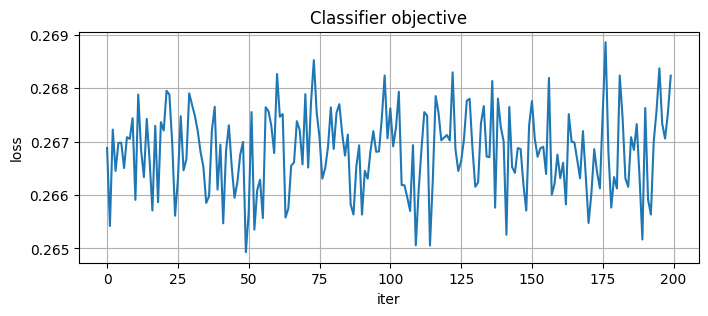

Accuracy  train: 0.4666666666666667
Accuracy    val: 0.4666666666666667
Accuracy   test: 0.4666666666666667

Confusion matrix:
 [[ 0 48]
 [ 0 42]]

Report:
               precision    recall  f1-score   support

           0      0.000     0.000     0.000        48
           1      0.467     1.000     0.636        42

    accuracy                          0.467        90
   macro avg      0.233     0.500     0.318        90
weighted avg      0.218     0.467     0.297        90



/home/trevor/git/fcc-jet-identification/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/trevor/git/fcc-jet-identification/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/trevor/git/fcc-jet-identification/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_p


Test ROC AUC: 0.436


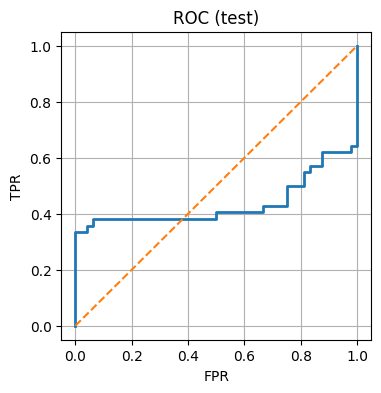

In [20]:
# === Train & test the QCNN head on the QAE latent ===
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve

# Encode inputs for the encoder's feature map (same mapping used during QAE training)
def encode_inputs(Xflat):
    return np.stack([to_angles(v) for v in Xflat], axis=0)

Xtr_ang = encode_inputs(X_train)
Xval_ang = encode_inputs(X_val)
Xte_ang  = encode_inputs(X_test)

# Fit classifier
def clf_callback(weights, obj_val):
    clear_output(wait=True)
    hist.append(obj_val)
    plt.figure(figsize=(8,3))
    plt.plot(hist); plt.title("Classifier objective"); plt.xlabel("iter"); plt.ylabel("loss")
    plt.grid(True); plt.show()

hist = []
clf = NeuralNetworkClassifier(
    neural_network=qnn_cls,          # built from (encoder + your QCNN ansatz)
    optimizer=COBYLA(maxiter=200),
    one_hot=False,                   # binary labels
    callback=clf_callback,
    warm_start=True,
)

clf.fit(Xtr_ang, y_train)

# Scores
print("Accuracy  train:", clf.score(Xtr_ang, y_train))
print("Accuracy    val:",   clf.score(Xval_ang, y_val))
print("Accuracy   test:",  clf.score(Xte_ang,  y_test))

# Detailed metrics on test
y_pred = clf.predict(Xte_ang)
print("\nConfusion matrix:\n", confusion_matrix(y_test, y_pred))
print("\nReport:\n", classification_report(y_test, y_pred, digits=3))

# ROC AUC using raw QNN outputs (expectation of Z mapped to [0,1])
raw_scores = qnn_cls.forward(Xte_ang, clf.weights)   # [-1, 1]
probs = (raw_scores + 1.0) / 2.0
auc = roc_auc_score(y_test, probs)
print(f"\nTest ROC AUC: {auc:.3f}")

fpr, tpr, _ = roc_curve(y_test, probs)
plt.figure(figsize=(4,4))
plt.plot(fpr, tpr, lw=2); plt.plot([0,1],[0,1],'--')
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC (test)")
plt.grid(True); plt.show()
